In [11]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import json
import os
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [4]:
# 1. Load the Data Splits (We need val_df for evaluation)
# print("Loading data splits...")
train_df = pd.read_parquet('../data/100k/train_final_mini.parquet') # Optional, but good to have
val_df = pd.read_parquet('../data/100k/val_final_mini.parquet')
test_df = pd.read_parquet('../data/100k/test_final_mini.parquet')

# 2. Load the Item Data (The "Phonebook" of items)
print("Loading item metadata...")
all_items_df = pd.read_parquet('../data/100k/all_items_processed_100k.parquet')

# 3. Load the Mappings (Vocabularies)
print("Loading vocabularies...")
def load_mapping(filename):
    with open(filename, 'r') as f:
        return json.load(f)

user_mapping = load_mapping('../data/user_mapping.json')
item_mapping = load_mapping('../data/item_mapping.json')

# 4. Load the Pre-Computed Item Embeddings (The "Fingerprints")
print("Loading item embeddings...")
item_embeddings = np.load('../data/100k/item_embeddings_100k.npy')

# 5. Load the Trained Model
print("Loading Keras model...")
model = tf.keras.models.load_model('../data/100k/two_tower_model_100k.keras')

print("\n--- Restore Complete! ---")
print(f"Model loaded: {model.name}")
print(f"Item Embeddings shape: {item_embeddings.shape}")
print(f"Validation set size: {len(val_df)}")

Loading item metadata...
Loading vocabularies...
Loading item embeddings...
Loading Keras model...

--- Restore Complete! ---
Model loaded: TwoTower_Hybrid
Item Embeddings shape: (48629, 32)
Validation set size: 10000


In [7]:

print("Re-extracting Item Tower from loaded model...")

# 1. Get the output of the item tower (the 'item_final' layer)
item_tower_output = model.get_layer('item_final').output

# 2. Re-create the sub-model
# Inputs are: item_input(1), brand_input(2), category_input(3), text_input(4)
# Note: input[0] is user_input, which we skip for the item tower
item_tower_model = Model(
    inputs=[
        model.input[1], 
        model.input[2], 
        model.input[3], 
        model.input[4]
    ],
    outputs=item_tower_output
)

print("Item Tower ready!")
item_tower_model.summary()

Re-extracting Item Tower from loaded model...
Item Tower ready!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ item_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ brand_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_emb            │ (None, 1, 32)     │  7,546,400 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ brand_emb           │ (None, 1, 16)     │    501,216 │ brand_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_emb        │ (None, 1, 16)     │     16,032 │ category_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 384)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ item_emb[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 16)        │          0 │ brand_emb[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 16)        │          0 │ category_emb[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_dense (Dense)  │ (None, 32)        │     12,320 │ text_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ text_dense[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_final (Dense)  │ (None, 32)        │      3,104 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,079,072 (30.82 MB)

 Trainable params: 8,079,072 (30.82 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# --- Configuration ---
TOP_K = 10
NUM_NEGATIVES = 50  # Compare real item against 50 random items

print(f"Starting Evaluation (Hit Rate@{TOP_K} and MRR)...")
print(f"Comparing each ground-truth item against {NUM_NEGATIVES} random negatives.")

# 1. Get all unique item IDs (for negative sampling)
all_item_ids = list(item_mapping.values())

# 2. Helper to get User and Item Vectors
# We need to pull these from the trained model layers
user_embedding_layer = model.get_layer('user_emb')
item_tower_model = item_tower_model # You already defined this in the previous task!

# Pre-compute ALL item vectors (we already did this, stored in 'item_embeddings')
# But we need a quick way to look them up by ID.
# Let's map Item ID -> Vector Index
# Note: In Task 2 of previous code, we reset index of all_items_df. 
# We need a map from 'item_id' (integer) to the row index in 'item_embeddings'
item_id_to_index = pd.Series(all_items_df.index, index=all_items_df['item_id']).to_dict()

# 3. Evaluation Loop
hits = 0
reciprocal_ranks = 0
total_evaluated = 0

# We'll just test on the first 1000 rows of validation data to save time
# (Standard academic practice is to sample if dataset is huge)
eval_data = val_df.head(1000)

for idx, row in eval_data.iterrows():
    # --- A. Get User Vector ---
    # We have to run the user ID through the embedding layer
    user_id = int(row['user_id'])
    
    # Handle Cold Start Users (ID 0)
    # If user_id is 0, the embedding is the "Unknown" vector (learned during training)
    user_vec = user_embedding_layer(np.array([user_id])) # Shape (1, 1, 32)
    user_vec = tf.reshape(user_vec, (1, 32)).numpy()     # Shape (1, 32)
    
    # --- B. Get Positive Item Vector ---
    pos_item_id = int(row['item_id'])
    if pos_item_id not in item_id_to_index:
        continue # Skip items not in our item bank
        
    pos_idx = item_id_to_index[pos_item_id]
    pos_item_vec = item_embeddings[pos_idx].reshape(1, -1)
    
    # --- C. Get Negative Item Vectors ---
    # Pick random item IDs that are NOT the positive one
    neg_vectors = []
    while len(neg_vectors) < NUM_NEGATIVES:
        random_id = random.choice(all_item_ids)
        if random_id != pos_item_id and random_id in item_id_to_index:
            neg_idx = item_id_to_index[random_id]
            neg_vectors.append(item_embeddings[neg_idx])
            
    neg_vectors = np.array(neg_vectors) # Shape (50, 32)
    
    # --- D. Calculate Scores ---
    # Dot product of User vs Positive
    pos_score = np.dot(user_vec, pos_item_vec.T).item()
    
    # Dot product of User vs Negatives
    neg_scores = np.dot(user_vec, neg_vectors.T).flatten()
    
    # --- E. Calculate Rank ---
    # Combine all scores
    all_scores = np.append(neg_scores, pos_score)
    # Rank them (descending). 'argsort' gives indices.
    # The positive item is the LAST one in the array (index 50)
    sorted_indices = np.argsort(all_scores)[::-1] # High to low
    
    # Find where the positive item ended up
    # The positive item was at index 'NUM_NEGATIVES' in the original 'all_scores'
    rank = np.where(sorted_indices == NUM_NEGATIVES)[0][0] + 1
    
    # --- F. Update Metrics ---
    if rank <= TOP_K:
        hits += 1
    
    reciprocal_ranks += 1 / rank
    total_evaluated += 1
    
    if total_evaluated % 200 == 0:
        print(f"Evaluated {total_evaluated} users...")

# --- 4. Final Results ---
hit_rate = hits / total_evaluated
mrr = reciprocal_ranks / total_evaluated

print("\n--- FINAL METRICS ---")
print(f"Hit Rate@{TOP_K}: {hit_rate:.4f}")
print(f"MRR:          {mrr:.4f}")

Starting Evaluation (Hit Rate@10 and MRR)...
Comparing each ground-truth item against 50 random negatives.
Evaluated 200 users...
Evaluated 400 users...
Evaluated 600 users...
Evaluated 800 users...
Evaluated 1000 users...

--- FINAL METRICS ---
Hit Rate@10: 0.3180
MRR:          0.1165


## The "Separation Plot" (Score Distribution)
The Question: "Does the model actually give higher scores to things users bought vs. random things?" The Visual: A histogram showing two overlapping distributions.

Green Curve: Scores for Real (Positive) items.

Red Curve: Scores for Random (Negative) items. The Goal: You want the Green curve to be shifted to the right of the Red curve. This proves the model has "discriminative power" even if the absolute ranking isn't perfect.

Generating Score Distribution Plot...


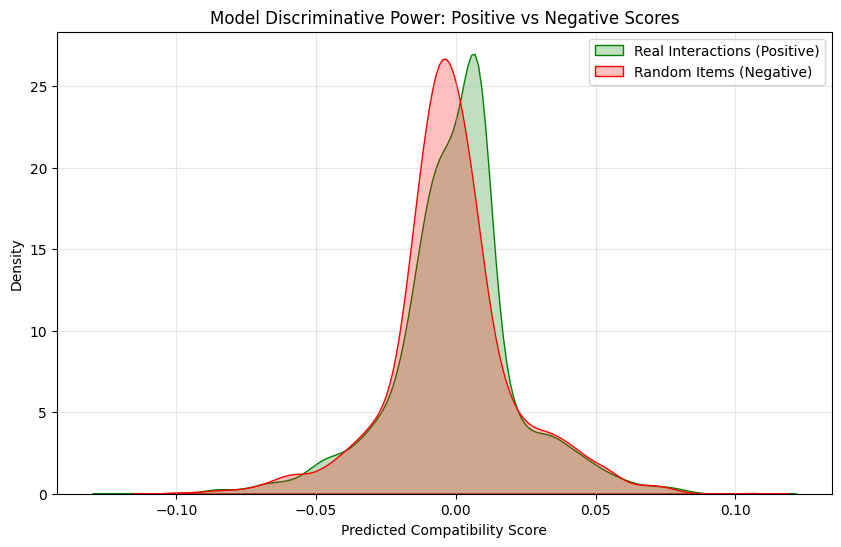

In [13]:
print("Generating Score Distribution Plot...")

# Configuration
num_samples = 2000 # Test on 2000 pairs

positive_scores = []
negative_scores = []

# Get layers from the model
user_emb_layer = model.get_layer('user_emb')

# Sample from validation data
sample_val = val_df.sample(n=num_samples, random_state=42)

for idx, row in sample_val.iterrows():
    # 1. Get User Vector
    uid = int(row['user_id'])
    # Handle cold start (map large IDs to 0 for visualization)
    if uid >= user_embedding_layer.input_dim: uid = 0
    
    user_vec = user_emb_layer(np.array([uid])).numpy().reshape(32)
    
    # 2. Get Positive Item Score
    iid = int(row['item_id'])
    if iid in item_id_to_index:
        idx = item_id_to_index[iid]
        pos_vec = item_embeddings[idx]
        positive_scores.append(np.dot(user_vec, pos_vec))
        
        # 3. Get Negative Item Score (Random)
        rand_idx = random.randint(0, len(item_embeddings)-1)
        neg_vec = item_embeddings[rand_idx]
        negative_scores.append(np.dot(user_vec, neg_vec))

# Plotting
plt.figure(figsize=(10, 6))

# --- THE FIX IS HERE: Changed shade=True to fill=True ---
sns.kdeplot(positive_scores, fill=True, color='green', label='Real Interactions (Positive)')
sns.kdeplot(negative_scores, fill=True, color='red', label='Random Items (Negative)')

plt.title('Model Discriminative Power: Positive vs Negative Scores')
plt.xlabel('Predicted Compatibility Score')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## The "Cluster Map" (t-SNE Visualization)
The Question: "Did the model learn that Laptops are different from Headphones?" The Visual: A 2D scatter plot where every dot is an item. We color the dots by their Category. The Goal: You should see distinct "islands" of colors (e.g., a cluster of Blue points for Laptops, a cluster of Red points for Cameras). This visually proves your Text Vectorization worked.

Generating t-SNE Cluster Map...


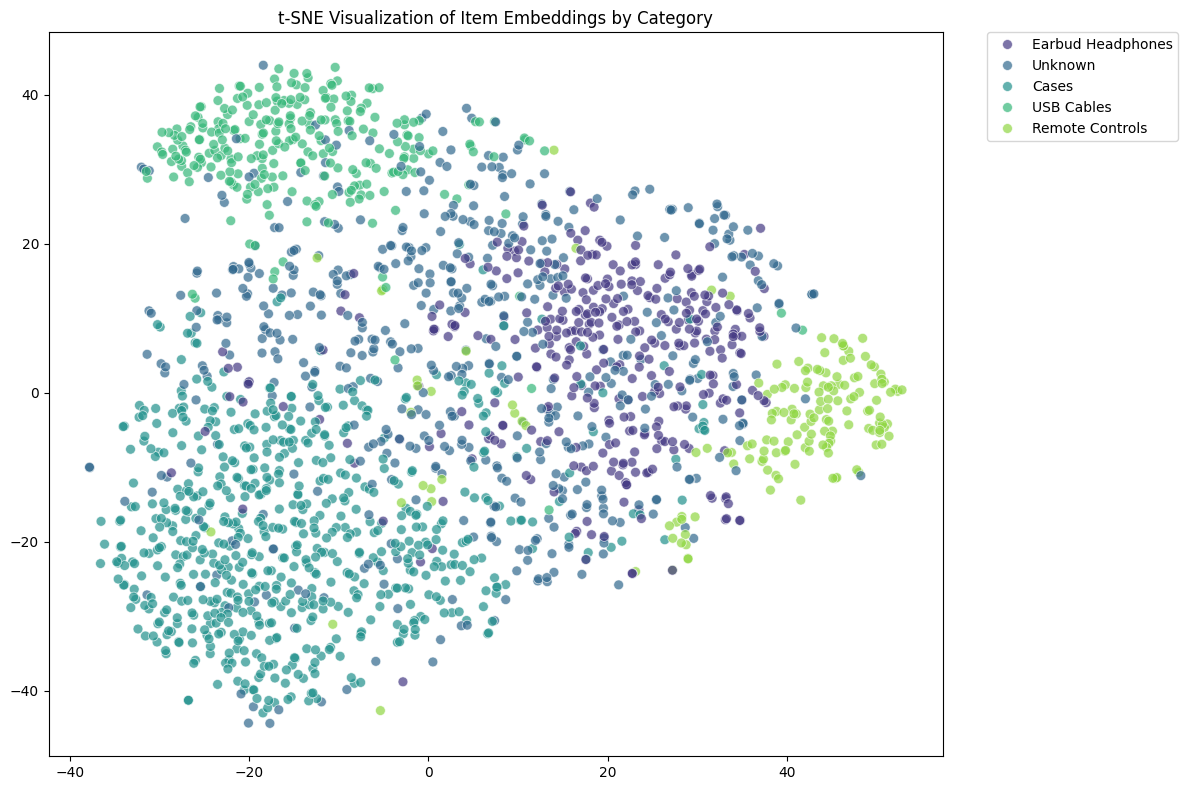

In [15]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

print("Generating t-SNE Cluster Map...")

# 1. Sample items to plot (Too many points looks messy)
# We pick top 5 categories to keep colors distinct
top_cats = all_items_df['main_category'].value_counts().head(5).index.tolist()
plot_df = all_items_df[all_items_df['main_category'].isin(top_cats)].sample(n=2000, random_state=42)

# 2. Get vectors for these items
indices = [item_id_to_index[iid] for iid in plot_df['item_id']]
vectors_to_plot = item_embeddings[indices]

# 3. Run t-SNE (Reduces 32 dimensions -> 2 dimensions)
# REMOVED 'n_iter=1000' since it is the default and was causing errors
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(vectors_to_plot)

# 4. Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=plot_df['main_category'],
    palette='viridis',
    s=50, alpha=0.7
)
plt.title('t-SNE Visualization of Item Embeddings by Category')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

## 03. Catalog Coverage (Diversity Metric)
The Question: "Is the model just recommending the same 10 popular items to everyone?" The Metric: Percentage of unique items recommended. The Goal: A higher number is usually better. It means your model is "exploring" the catalog and finding niche items, not just playing it safe.

In [16]:
print("Calculating Catalog Coverage...")

# Recommend top 10 items for 500 random users
sample_users = val_df['user_id'].sample(500, random_state=42).unique()
unique_recommended_items = set()

for uid in sample_users:
    # Handle user vector
    if uid >= user_embedding_layer.input_dim: uid = 0
    user_vec = user_emb_layer(np.array([uid])).numpy().reshape(1, 32)
    
    # Calculate scores for ALL items
    scores = np.dot(item_embeddings, user_vec.T).flatten()
    
    # Get top 10 indices
    top_indices = np.argpartition(scores, -10)[-10:]
    
    # Map back to Item IDs
    for idx in top_indices:
        # We need to find the item_id for this index (reverse lookup)
        # For simplicity, we just count the unique INDEXES recommended
        unique_recommended_items.add(idx)

# Calculate Metric
total_items = len(item_embeddings)
coverage = len(unique_recommended_items) / total_items
print(f"Total Unique Items Recommended: {len(unique_recommended_items)}")
print(f"Catalog Coverage: {coverage*100:.2f}%")

Calculating Catalog Coverage...
Total Unique Items Recommended: 1463
Catalog Coverage: 3.01%
